In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.metrics import mean_squared_error as auto_mean_squared_error
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyparsing.py:3172: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


In [2]:
# load dataset
debt_market_df = pd.read_csv('debt_market_df.csv', index_col='date', parse_dates=True)


def fitmodel(data_to_fit=debt_market_df, 
             data_to_predict=debt_market_df, 
             target_col='p',
             features=None, 
             verbose=False, 
             test_size=0.33
            ):
    if not features:
        features = ['beta', 'Q', 'v_1', 'v_2 + v_3', 
                    'rho_star', 'C_star',
                    'D_1', 'u_1', 'u_2', 'u_3', 'u_2 + u_3', 
                    'D_2', 'w_1', 'w_2', 'w_3', 'w_2 + w_3',
                    'D']
    target = data_to_fit[target_col].copy()
    
    data_to_fit = data_to_fit[features]
    data_to_predict = data_to_predict[features]
    
    X_train, X_test, y_train, y_test = train_test_split(data_to_fit, target, test_size=test_size, random_state=1)
    
    model = AutoSklearnRegressor(time_left_for_this_task=5*60, 
                                 per_run_time_limit=30, 
                                 n_jobs=8,
                                 resampling_strategy='cv',
                                 resampling_strategy_arguments={'folds':5}
                                )
    model.fit(X_train, y_train)
    if verbose:
        print(model.sprint_statistics())
        models = model.get_models_with_weights()
        for m in models:
            print({m[0]: m[1].config['regressor:__choice__']})
    return model, model.predict(data_to_predict), y_test, model.predict(X_test)

def get_model_summary(model):
    result = []
    models = model.get_models_with_weights()
    for m in models:
        result.append((m[0],m[1].config['regressor:__choice__']))
    return result

In [3]:
p_ema_estimates = pd.DataFrame(debt_market_df['p_ema_10'])
i = 1

Fitting model using 66% of the data for training
[WARNING] [2020-09-16 16:08:20,238:AutoMLSMBO(1791095845)::f55f7e85530272cf61a7d06b7f6532dd] Could not find meta-data directory /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/autosklearn/metalearning/files/r2_regression_dense
auto-sklearn results:
  Dataset name: f55f7e85530272cf61a7d06b7f6532dd
  Metric: r2
  Best validation score: 0.915448
  Number of target algorithm runs: 93
  Number of successful target algorithm runs: 59
  Number of crashed target algorithm runs: 1
  Number of target algorithms that exceeded the time limit: 33
  Number of target algorithms that exceeded the memory limit: 0

{0.34: 'k_nearest_neighbors'}
{0.24: 'k_nearest_neighbors'}
{0.12: 'adaboost'}
{0.08: 'k_nearest_neighbors'}
{0.06: 'ridge_regression'}
{0.04: 'k_nearest_neighbors'}
{0.04: 'k_nearest_neighbors'}
{0.02: 'k_nearest_neighbors'}
{0.02: 'extra_trees'}
{0.02: 'adaboost'}
{0.02: 'ridge_regression'}
R2: 0.9245258554176732

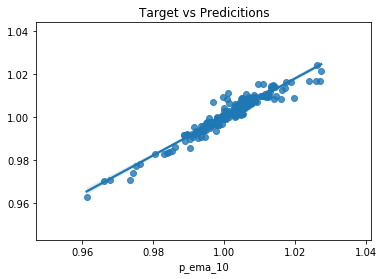

In [4]:
print('Fitting model using 66% of the data for training')
model, full_prediction, y_test, predicted_y_test = fitmodel(test_size=0.34, target_col='p_ema_10', verbose=True)
r2 = r2_score(y_test,predicted_y_test)
print(f'R2: {r2}')
p_ema_estimates[f'p_ema_hat_{i} R2={r2:.2f}'] = full_prediction
pprint(get_model_summary(model))
sns.regplot(y_test, predicted_y_test).set_title('Target vs Predicitions');
print('---')
i += 1

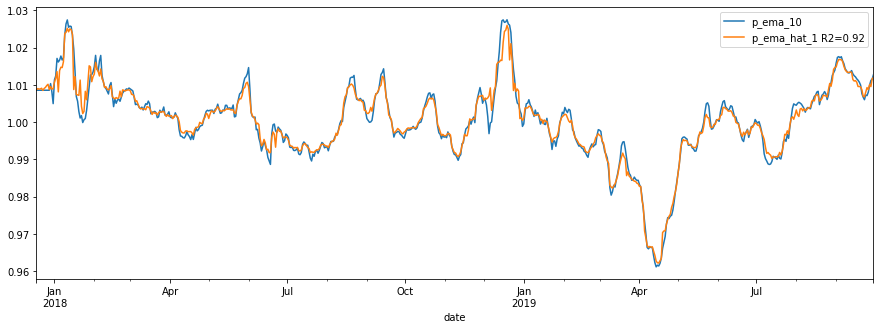

In [5]:
p_ema_estimates.plot(figsize=(15,5))

In [6]:
# Store the last model in a file and load it to check the predictions match
import pickle
pickle.dump(model, open('debt_price_estimator.pickle', 'wb'))
loaded_model = pickle.load(open('debt_price_estimator.pickle', 'rb'))

features = ['beta', 'Q', 'v_1', 'v_2 + v_3', 
            'rho_star', 'C_star',
            'D_1', 'u_1', 'u_2', 'u_3', 'u_2 + u_3', 
            'D_2', 'w_1', 'w_2', 'w_3', 'w_2 + w_3',
            'D']

def transform(df):        
    df = df[features].copy()
#     df_deltas = df.diff()
#     df_deltas.iloc[0] = df.iloc[0].copy()
#     df = df.join(df_deltas, rsuffix='_delta')
    return df
    
data_to_predict = transform(debt_market_df)
loaded_model_predictions = loaded_model.predict(data_to_predict)
print(f'Prediction by the model loaded from file matches original: {(full_prediction==loaded_model_predictions).all()}')

Prediction by the model loaded from file matches original: True


In [7]:
autoreg_df = debt_market_df[['p', 'p_star']].copy()
autoreg_df['p_hat'] = full_prediction
autoreg_df['e_hat'] = autoreg_df['p_hat'] - autoreg_df['p']
autoreg_df['e_star'] = autoreg_df['p_star'] - autoreg_df['p']
autoreg_df['cumsum_e_hat'] = autoreg_df['e_hat'].cumsum()
autoreg_df['cumsum_e_star'] = autoreg_df['e_star'].cumsum()
autoreg_df['delta_e_hat'] = autoreg_df['e_hat'].diff().fillna(autoreg_df['e_hat'])
autoreg_df['delta_e_star'] = autoreg_df['e_star'].diff().fillna(autoreg_df['e_star'])
autoreg_df['y'] = autoreg_df['p'].shift(-1)
autoreg_df.dropna(inplace=True)
autoreg_df.to_csv('market_price_autoregression_df.csv')